Student ID: M1332012   

Name: Chia Hwe Huang

# Question 1

Utilize ResNet-18 for classifying Fashion MNIST. Train the network. Calculate the accuracy on the
training set, validation set, and test set. Then, contrast the performance with ResNet-34.

The revolution/architecture of different variants of ResNets are given below:

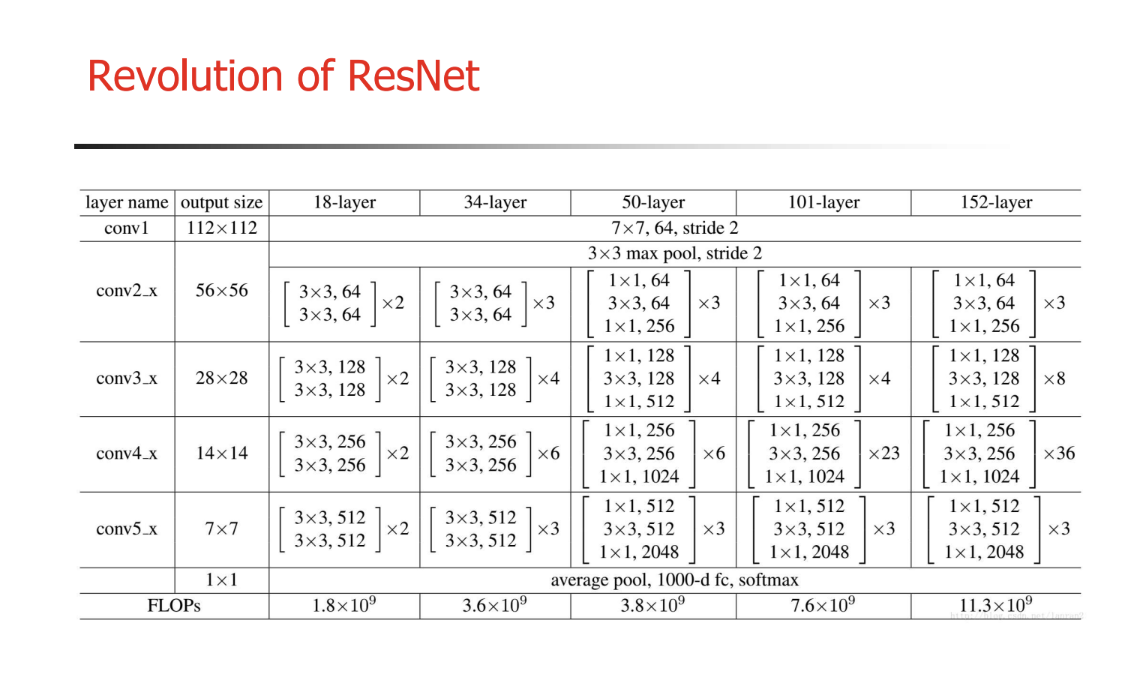

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation_fn = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(activation),
            tf.keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation_fn(Z + skip_Z)

class ResNet18(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.resize = tf.keras.layers.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape)
        self.initial_layers = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
        ])
        self.residual_blocks = tf.keras.Sequential()
        self._build_resnet_blocks()
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def _build_resnet_blocks(self):
        filters_per_stage = [64, 128, 256, 512]
        blocks_per_stage = [2, 2, 2, 2]  # ResNet-18 architecture
        #blocks_per_stage =[3,4,6,3] #ResNet-34 architecture
        prev_filters = 64
        for filters, blocks in zip(filters_per_stage, blocks_per_stage):
            for block in range(blocks):
                strides = 1 if block > 0 else (1 if filters == prev_filters else 2)
                self.residual_blocks.add(ResidualUnit(filters, strides=strides))
                prev_filters = filters

    def call(self, inputs):
        x = self.resize(inputs)
        x = self.initial_layers(x)
        x = self.residual_blocks(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        return self.classifier(x)

# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
val_split = int(0.1 * X_train.shape[0])
X_val = X_train[:val_split]
y_val = y_train[:val_split]
X_train = X_train[val_split:]
y_train = y_train[val_split:]

# Hyperparameters
learning_rate = 0.01
batch_size = 32

# Prepare datasets (helps with computation time)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Instantiate and compile model
model = ResNet18(input_shape=(28, 28, 1), num_classes=10)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.build(input_shape=(None, 28, 28, 1))
model.summary()

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Evaluate
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)
test_loss, test_accuracy = model.evaluate(test_ds)

print("\nEvaluation Results:")
print("Training Loss: {:.4f}  Training Accuracy: {:.4f}".format(train_loss, train_accuracy))
print("Validation Loss: {:.4f}  Validation Accuracy: {:.4f}".format(val_loss, val_accuracy))
print("Test Loss: {:.4f}  Test Accuracy: {:.4f}".format(test_loss, test_accuracy))

# Plot history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Train Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Question 2

Repeat Question 1 using ResNet-50

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

class BottleneckBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu",input_filters=None, **kwargs):
        super().__init__(**kwargs)
        bottleneck_filters = filters // 4
        self.activation_fn = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(bottleneck_filters, 1, strides=strides, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(activation),

            tf.keras.layers.Conv2D(bottleneck_filters, 3, strides=1, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(activation),

            tf.keras.layers.Conv2D(filters, 1, strides=1, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1 or filters != kwargs.get("input_filters", filters):
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation_fn(Z + skip_Z)

class ResNet50(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.resize = tf.keras.layers.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape)
        self.initial_layers = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
        ])
        self.residual_blocks = tf.keras.Sequential()
        self._build_resnet50_blocks()
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def _build_resnet50_blocks(self):
        filters_per_stage = [256, 512, 1024, 2048]
        blocks_per_stage = [3, 4, 6, 3]  # ResNet-50 architecture
        prev_filters = 64
        for filters, blocks in zip(filters_per_stage, blocks_per_stage):
            for block in range(blocks):
                strides = 1 if block > 0 else (1 if filters == prev_filters else 2)
                self.residual_blocks.add(BottleneckBlock(filters, strides=strides, input_filters=prev_filters))
                prev_filters = filters

    def call(self, inputs):
        x = self.resize(inputs)
        x = self.initial_layers(x)
        x = self.residual_blocks(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        return self.classifier(x)

# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
val_split = int(0.1 * X_train.shape[0])
X_val = X_train[:val_split]
y_val = y_train[:val_split]
X_train = X_train[val_split:]
y_train = y_train[val_split:]

# Hyperparameters
learning_rate = 0.01
batch_size = 64

# Prepare datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Instantiate and compile model
model = ResNet50(input_shape=(28, 28, 1), num_classes=10)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.build(input_shape=(None, 28, 28, 1))
model.summary()

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=2)

# Evaluate
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)
test_loss, test_accuracy = model.evaluate(test_ds)

print("\nEvaluation Results:")
print("Training Loss: {:.4f}  Training Accuracy: {:.4f}".format(train_loss, train_accuracy))
print("Validation Loss: {:.4f}  Validation Accuracy: {:.4f}".format(val_loss, val_accuracy))
print("Test Loss: {:.4f}  Test Accuracy: {:.4f}".format(test_loss, test_accuracy))

# Plot history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Train Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
